In [1]:
# Cell 1 — install
!pip install -q transformers datasets accelerate evaluate scikit-learn sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00


In [2]:
# Cell 3 — upload local file via browser
from google.colab import files
uploaded = files.upload()   # choose your tamil_sentiment_full.csv from your machine
# After upload, file will be in current working directory, e.g. '/content/tamil_sentiment_full.csv'

Saving tamil_sentiment_full.csv to tamil_sentiment_full.csv


In [4]:
DATA_PATH = 'tamil_sentiment_full.csv'   # update if needed

# print first 120 lines and lines around line 51
with open(DATA_PATH, 'r', encoding='utf-8', errors='replace') as f:
    lines = f.readlines()

print("Total lines:", len(lines))
print("\n--- first 20 lines ---")
for i, line in enumerate(lines[:20], 1):
    print(f"{i:03d}: {line.rstrip()!r}")

print("\n--- around line 51 (±5) ---")
start = max(0, 50-5)   # zero-indexed
for i in range(start, min(len(lines), 50+5)):
    print(f"{i+1:03d}: {lines[i].rstrip()!r}")

Total lines: 44161

--- first 20 lines ---
001: 'Negative\tEnna da ellam avan seyal  Mari iruku'
002: 'Negative\tThis movei is just like  ellam avan seyal'
003: 'Positive\tPadam vanthathum 13k dislike pottavaga yellam yea da dislike  pannom nu feel pannanum'
004: 'Positive\tNeraya neraya neraya... ... V era level...thala'
005: 'Positive\twow thavala sema mass....padam oru pundaikum aagathu'
006: 'Negative\tAndha 19 k unlike panavangaluku kolandha porakathu'
007: 'Positive\tYaarellam frst like pottutu video paaka start paneenga....hit like'
008: 'Positive\tEthana padam vanthanu SALT AND PEPPER Mattum than..THÃLÃ🤩🤩'
009: 'Positive\tThala mass  Hvy sprt kerala Surya anna fans'
010: 'Negative\tElam avan jayal movie  remake pa'
011: "Positive\tDhayavasenju indha padathula mass ila mayiru ila nu yevanum saavadikadheenga.. let him do such roles.. it's healthy!"
012: 'Positive\tvera lvl.... Thala sammaaaaaaaaaaaaa......Bgm sammaya iruku'
013: 'Positive\tRomba nal aparam ajith ah normal ah paka

In [5]:
# Clean tab-quoted file and produce a tidy CSV for training
DATA_PATH = 'tamil_sentiment_full.csv'   # your uploaded file
CLEAN_PATH = 'tamil_sentiment_full.cleaned.csv'

rows = []
bad_lines = []
with open(DATA_PATH, 'r', encoding='utf-8', errors='replace') as f:
    for i, raw in enumerate(f, 1):
        line = raw.rstrip('\n').rstrip('\r')
        if not line.strip():
            continue
        # remove a single leading and trailing single-quote if present
        if line.startswith("'") and line.endswith("'"):
            line = line[1:-1]
        # split on the first tab into label and text
        if '\t' in line:
            label, text = line.split('\t', 1)
            rows.append((label.strip(), text.strip()))
        else:
            # keep track of malformed lines
            bad_lines.append((i, line))

# Build DataFrame
import pandas as pd
clean_df = pd.DataFrame(rows, columns=['label', 'text'])
print(f"Cleaned rows: {len(clean_df)}  |  Malformed (no tab) lines: {len(bad_lines)}")

# Show a few malformed lines (if any) so you can inspect
if bad_lines:
    print("\nSample malformed lines (line_no, content):")
    for ln, content in bad_lines[:10]:
        print(ln, repr(content))

# Basic sanity checks
print("\nSample rows:")
display(clean_df.head(8))
print("\nLabel distribution:")
display(clean_df['label'].value_counts())

# Save cleaned CSV (comma-separated). If you prefer TSV, change sep='\t'
clean_df.to_csv(CLEAN_PATH, index=False, encoding='utf-8')
print(f"\nSaved cleaned CSV -> {CLEAN_PATH}")

Cleaned rows: 44020  |  Malformed (no tab) lines: 0

Sample rows:


,label,text
0,Negative,Enna da ellam avan seyal Mari iruku
1,Negative,This movei is just like ellam avan seyal
2,Positive,Padam vanthathum 13k dislike pottavaga yellam ...
3,Positive,Neraya neraya neraya... ... V era level...thala
4,Positive,wow thavala sema mass....padam oru pundaikum a...
5,Negative,Andha 19 k unlike panavangaluku kolandha porak...
6,Positive,Yaarellam frst like pottutu video paaka start ...
7,Positive,Ethana padam vanthanu SALT AND PEPPER Mattum t...



Label distribution:


,count
label,
Positive,24873
unknown_state,6904
Negative,5228
Mixed_feelings,4928
not-Tamil,2087



Saved cleaned CSV -> tamil_sentiment_full.cleaned.csv


Loaded rows: 44020
Label counts:
label
Positive          24873
unknown_state      6904
Negative           5228
Mixed_feelings     4928
not-Tamil          2087
Name: count, dtype: int64
Classes (id -> label): [(0, 'Mixed_feelings'), (1, 'Negative'), (2, 'Positive'), (3, 'not-Tamil'), (4, 'unknown_state')]
Train size: 35216 Test size: 8804
Class weights (numpy): [1.78670726 1.68417025 0.35394743 4.21748503 1.27524896]

==== TRAINING mBERT (bert-base-multilingual-cased) ====


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/35216 [00:00<?, ? examples/s]

Map:   0%|          | 0/8804 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.215700,1.181643,0.455610,0.524901,0.467797
2,1.067900,1.144367,0.472545,0.553376,0.495449
3,0.943200,1.213857,0.481956,0.547628,0.502154


Eval (macro metrics): {'eval_loss': 1.2138569355010986, 'eval_precision': 0.4819557808189921, 'eval_recall': 0.5476276730804173, 'eval_f1': 0.5021541170409181, 'eval_runtime': 13.0633, 'eval_samples_per_second': 673.951, 'eval_steps_per_second': 42.179}

Classification report for mBERT:
                 precision    recall  f1-score   support

Mixed_feelings     0.2729    0.3661    0.3127       986
      Negative     0.3794    0.4962    0.4300      1046
      Positive     0.8454    0.6078    0.7071      4974
     not-Tamil     0.5255    0.7170    0.6065       417
 unknown_state     0.3867    0.5510    0.4545      1381

      accuracy                         0.5637      8804
     macro avg     0.4820    0.5476    0.5022      8804
  weighted avg     0.6388    0.5637    0.5856      8804

Confusion matrix (normalized) shape: (5, 5)
Saved model outputs to: ./model_outputs/mBERT


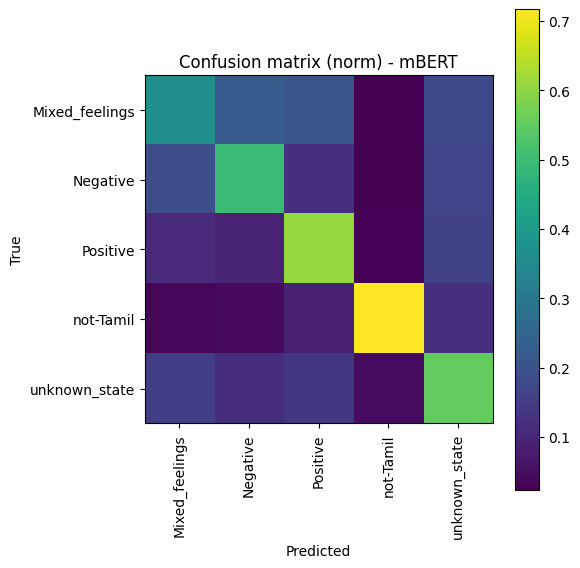


==== TRAINING MuRIL (google/muril-base-cased) ====


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/35216 [00:00<?, ? examples/s]

Map:   0%|          | 0/8804 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.388100,1.345747,0.314742,0.407513,0.332544
2,1.299700,1.297586,0.432780,0.473059,0.446116
3,1.223000,1.276446,0.453945,0.485590,0.461510


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Eval (macro metrics): {'eval_loss': 1.2764461040496826, 'eval_precision': 0.4539450944329134, 'eval_recall': 0.4855897641237382, 'eval_f1': 0.4615104410006573, 'eval_runtime': 10.3816, 'eval_samples_per_second': 848.038, 'eval_steps_per_second': 53.075}

Classification report for MuRIL:
                 precision    recall  f1-score   support

Mixed_feelings     0.2240    0.2252    0.2246       986
      Negative     0.3417    0.5449    0.4200      1046
      Positive     0.7932    0.6192    0.6955      4974
     not-Tamil     0.5986    0.6259    0.6120       417
 unknown_state     0.3122    0.4127    0.3555      1381

      accuracy                         0.5342      8804
     macro avg     0.4539    0.4856    0.4615      8804
  weighted avg     0.5911    0.5342    0.5527      8804

Confusion matrix (normalized) shape: (5, 5)
Saved model outputs to: ./model_outputs/MuRIL


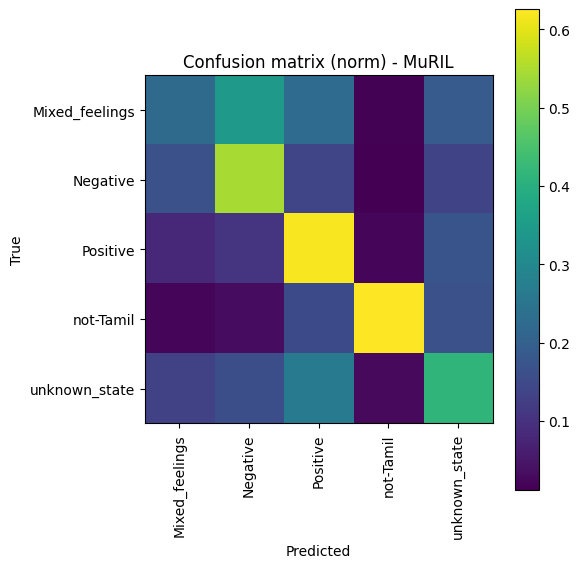


==== TRAINING IndicBERT (ai4bharat/indic-bert) ====


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/35216 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

Map:   0%|          | 0/8804 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.426600,1.467894,0.347547,0.348588,0.308328
2,1.312800,1.302594,0.436537,0.455954,0.401631
3,1.262400,1.285420,0.429786,0.477794,0.434382


Eval (macro metrics): {'eval_loss': 1.285420298576355, 'eval_precision': 0.4297862655982193, 'eval_recall': 0.47779390286283574, 'eval_f1': 0.4343821368922594, 'eval_runtime': 10.6895, 'eval_samples_per_second': 823.613, 'eval_steps_per_second': 51.546}

Classification report for IndicBERT:
                 precision    recall  f1-score   support

Mixed_feelings     0.2838    0.2343    0.2567       986
      Negative     0.2736    0.5172    0.3579      1046
      Positive     0.8259    0.5495    0.6599      4974
     not-Tamil     0.4549    0.6043    0.5191       417
 unknown_state     0.3107    0.4837    0.3784      1381

      accuracy                         0.5026      8804
     macro avg     0.4298    0.4778    0.4344      8804
  weighted avg     0.6012    0.5026    0.5280      8804

Confusion matrix (normalized) shape: (5, 5)
Saved model outputs to: ./model_outputs/IndicBERT


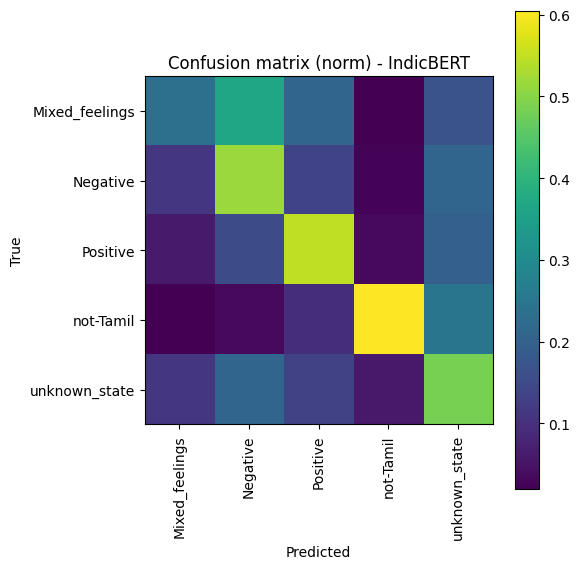


Model comparison (macro metrics):
       model                      model_id  precision    recall        f1
0      mBERT  bert-base-multilingual-cased   0.481956  0.547628  0.502154
1      MuRIL       google/muril-base-cased   0.453945  0.485590  0.461510
2  IndicBERT          ai4bharat/indic-bert   0.429786  0.477794  0.434382

Saved model_comparison_results_weighted.csv and model outputs under ./model_outputs


In [8]:
# FIXED: CLASS-WEIGHTED TRAINING PIPELINE (Colab-ready single cell)
# Requirements (run once in Colab):
# !pip install -q transformers datasets accelerate evaluate scikit-learn sentencepiece

import os
os.environ["WANDB_DISABLED"] = "true"   # disable W&B prompt early

import random
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import evaluate
import matplotlib.pyplot as plt

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

# ---------------- CONFIG ----------------
DATA_PATH = 'tamil_sentiment_full.cleaned.csv'   # update if needed
MODEL_IDS = {
    'mBERT': 'bert-base-multilingual-cased',
    'MuRIL': 'google/muril-base-cased',
    'IndicBERT': 'ai4bharat/indic-bert'
}
OUTPUT_DIR = './model_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

EPOCHS = 3
BATCH_SIZE = 16
LR = 2e-5
MAX_LENGTH = 256           # reduce to 128 if OOM
FP16 = True                # set False if GPU doesn't support fp16
GRAD_ACCUM_STEPS = 1       # increase to simulate larger batch
# ----------------------------------------

# Load cleaned data
df = pd.read_csv(DATA_PATH, encoding='utf-8')
print("Loaded rows:", len(df))
print("Label counts:")
print(df['label'].value_counts())

# Encode labels
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
num_labels = len(le.classes_)
print("Classes (id -> label):", list(enumerate(le.classes_)))

# Train-test split (stratified)
train_df, test_df = train_test_split(df[['text','label_enc']], test_size=0.2, random_state=SEED, stratify=df['label_enc'])
train_df = train_df.reset_index(drop=True); test_df = test_df.reset_index(drop=True)
print('Train size:', len(train_df), 'Test size:', len(test_df))

# Compute class weights (sklearn: weight for each class id)
class_weights_np = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['label_enc']), y=train_df['label_enc'])
print("Class weights (numpy):", class_weights_np)

# Prepare metrics
metric_precision = evaluate.load('precision')
metric_recall = evaluate.load('recall')
metric_f1 = evaluate.load('f1')

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    p = metric_precision.compute(predictions=preds, references=labels, average='macro')['precision']
    r = metric_recall.compute(predictions=preds, references=labels, average='macro')['recall']
    f = metric_f1.compute(predictions=preds, references=labels, average='macro')['f1']
    return {'precision': p, 'recall': r, 'f1': f}

# Custom Trainer to inject class weights into loss (accept arbitrary kwargs)
class WeightedTrainer(Trainer):
    def __init__(self, class_weights_tensor=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights_tensor = class_weights_tensor

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Compute weighted CrossEntropy loss. Accepts extra kwargs from Trainer.
        """
        # keep labels separate
        labels = inputs.get("labels")
        # forward pass with inputs excluding labels (some models accept labels to compute loss; we compute loss ourselves)
        inputs_for_model = {k: v for k, v in inputs.items() if k != "labels"}
        outputs = model(**inputs_for_model)
        logits = outputs.logits

        # prepare class weights on correct device and dtype
        if self.class_weights_tensor is not None:
            weight = self.class_weights_tensor.to(logits.device).to(logits.dtype)
        else:
            weight = None

        loss_fct = torch.nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

results = []

for short_name, model_id in MODEL_IDS.items():
    print(f"\n==== TRAINING {short_name} ({model_id}) ====")
    tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=num_labels)

    # create HF datasets
    ds_train = Dataset.from_pandas(train_df.rename(columns={'label_enc':'label'}))
    ds_test = Dataset.from_pandas(test_df.rename(columns={'label_enc':'label'}))

    def preprocess_fn(examples):
        return tokenizer(examples['text'], truncation=True, padding=False, max_length=MAX_LENGTH)
    ds_train = ds_train.map(preprocess_fn, batched=True)
    ds_test = ds_test.map(preprocess_fn, batched=True)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    model_output = os.path.join(OUTPUT_DIR, short_name)
    training_args = TrainingArguments(
        output_dir=model_output,
        eval_strategy='epoch',   # correct argument name
        save_strategy='epoch',
        learning_rate=LR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        seed=SEED,
        logging_steps=200,
        fp16=FP16 if torch.cuda.is_available() else False,
        gradient_accumulation_steps=GRAD_ACCUM_STEPS,
        save_total_limit=2,
        report_to=[]                  # disable trackers (wandb/tensorboard)
    )

    # cast class weights to tensor (float)
    class_weights_tensor = torch.tensor(class_weights_np, dtype=torch.float)

    trainer = WeightedTrainer(
        class_weights_tensor=class_weights_tensor,
        model=model,
        args=training_args,
        train_dataset=ds_train,
        eval_dataset=ds_test,
        # do NOT pass tokenizer to Trainer to avoid deprecation warning
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    # Train
    trainer.train()

    # Evaluate (macro metrics)
    eval_res = trainer.evaluate(eval_dataset=ds_test)
    print('Eval (macro metrics):', {k:v for k,v in eval_res.items() if k.startswith('eval_')})

    # Predict to get detailed per-class results
    preds_output = trainer.predict(ds_test)
    preds = np.argmax(preds_output.predictions, axis=1)
    labels = preds_output.label_ids

    # classification report & confusion matrix
    report = classification_report(labels, preds, target_names=le.classes_, digits=4, zero_division=0)
    print(f"\nClassification report for {short_name}:\n", report)
    cm = confusion_matrix(labels, preds, normalize='true')
    print("Confusion matrix (normalized) shape:", cm.shape)

    # Save artifacts
    os.makedirs(model_output, exist_ok=True)
    with open(os.path.join(model_output, 'classification_report.txt'), 'w', encoding='utf-8') as fh:
        fh.write(report)
    np.savetxt(os.path.join(model_output, 'confusion_matrix_norm.csv'), cm, delimiter=',')

    # Save model: Trainer already saves model checkpoints; copy best model folder if needed.
    print(f"Saved model outputs to: {model_output}")

    results.append({
        'model': short_name,
        'model_id': model_id,
        'precision': float(eval_res.get('eval_precision', np.nan)),
        'recall': float(eval_res.get('eval_recall', np.nan)),
        'f1': float(eval_res.get('eval_f1', np.nan))
    })

    # quick confusion matrix plot inline
    plt.figure(figsize=(6,6))
    plt.imshow(cm, aspect='equal')
    plt.title(f'Confusion matrix (norm) - {short_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(ticks=np.arange(len(le.classes_)), labels=le.classes_, rotation=90)
    plt.yticks(ticks=np.arange(len(le.classes_)), labels=le.classes_)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Summarize and save comparison table
results_df = pd.DataFrame(results).sort_values('f1', ascending=False).reset_index(drop=True)
results_df.to_csv('model_comparison_results_weighted.csv', index=False)
print("\nModel comparison (macro metrics):")
print(results_df)
print("\nSaved model_comparison_results_weighted.csv and model outputs under", OUTPUT_DIR)


In [9]:
# BERT-family training pipeline (mBERT, MuRIL, IndicBERT, XLM-R) — 5 epochs, class-weighted
# Requirements (run once): !pip install -q transformers datasets accelerate evaluate scikit-learn sentencepiece

import os
os.environ["WANDB_DISABLED"] = "true"   # disable W&B prompt

import random, numpy as np, pandas as pd, torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import evaluate
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)

# ---------- CONFIG ----------
DATA_PATH = 'tamil_sentiment_full.cleaned.csv'   # ensure this file is uploaded in Colab
MODEL_IDS = {
    'mBERT': 'bert-base-multilingual-cased',
    'MuRIL': 'google/muril-base-cased',
    'IndicBERT': 'ai4bharat/indic-bert',
    'XLM-R': 'xlm-roberta-base'
}
OUTPUT_DIR = './bert_models'
os.makedirs(OUTPUT_DIR, exist_ok=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

EPOCHS = 5                # <--- you requested at least 5 epochs
BATCH_SIZE = 16           # reduce if OOM (8 or 4)
LR = 2e-5
MAX_LENGTH = 256          # reduce to 128 if OOM
FP16 = True if torch.cuda.is_available() else False
GRAD_ACCUM = 1
# ----------------------------

# Load data
df = pd.read_csv(DATA_PATH, encoding='utf-8')
assert 'text' in df.columns and 'label' in df.columns, "CSV must contain 'text' and 'label' columns"
df['text'] = df['text'].astype(str)

# Label encode
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
num_labels = len(le.classes_)
print("Classes (id->label):", list(enumerate(le.classes_)))

# Train/test split (stratified)
train_df, test_df = train_test_split(df[['text','label_enc']], test_size=0.2, random_state=SEED, stratify=df['label_enc'])
train_df = train_df.reset_index(drop=True); test_df = test_df.reset_index(drop=True)
print("Train / Test sizes:", len(train_df), len(test_df))

# Compute class weights (balanced)
class_weights_np = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['label_enc']), y=train_df['label_enc'])
class_weights_tensor = torch.tensor(class_weights_np, dtype=torch.float)
print("Class weights:", class_weights_np)

# Prepare metrics
metric_precision = evaluate.load('precision')
metric_recall = evaluate.load('recall')
metric_f1 = evaluate.load('f1')
def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    if isinstance(logits, tuple): logits = logits[0]
    preds = np.argmax(logits, axis=1)
    p = metric_precision.compute(predictions=preds, references=labels, average='macro')['precision']
    r = metric_recall.compute(predictions=preds, references=labels, average='macro')['recall']
    f = metric_f1.compute(predictions=preds, references=labels, average='macro')['f1']
    return {'precision': p, 'recall': r, 'f1': f}

# Custom Trainer to inject class weights; accept arbitrary kwargs to be compatible
from transformers import Trainer as HfTrainer
class WeightedTrainer(HfTrainer):
    def __init__(self, class_weights_tensor=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights_tensor = class_weights_tensor

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        inputs_for_model = {k:v for k,v in inputs.items() if k != "labels"}
        outputs = model(**inputs_for_model)
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
        weight = self.class_weights_tensor.to(logits.device).to(logits.dtype) if self.class_weights_tensor is not None else None
        loss_fct = torch.nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

results = []

for short_name, model_id in MODEL_IDS.items():
    print(f"\n=== TRAINING {short_name} ({model_id}) ===")
    tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=num_labels)

    # Prepare datasets
    ds_train = Dataset.from_pandas(train_df.rename(columns={'label_enc':'label'}))
    ds_test = Dataset.from_pandas(test_df.rename(columns={'label_enc':'label'}))

    def preprocess(examples):
        return tokenizer(examples['text'], truncation=True, padding=False, max_length=MAX_LENGTH)
    ds_train = ds_train.map(preprocess, batched=True)
    ds_test = ds_test.map(preprocess, batched=True)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    model_output = os.path.join(OUTPUT_DIR, short_name)
    training_args = TrainingArguments(
        output_dir=model_output,
        eval_strategy='epoch',
        save_strategy='epoch',
        learning_rate=LR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        seed=SEED,
        logging_steps=200,
        fp16=FP16,
        gradient_accumulation_steps=GRAD_ACCUM,
        save_total_limit=2,
        report_to=[]      # disables W&B / trackers
    )

    trainer = WeightedTrainer(
        class_weights_tensor=class_weights_tensor,
        model=model,
        args=training_args,
        train_dataset=ds_train,
        eval_dataset=ds_test,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    # Train
    trainer.train()

    # Evaluate
    eval_res = trainer.evaluate(eval_dataset=ds_test)
    print('Eval (macro metrics):', {k:v for k,v in eval_res.items() if k.startswith('eval_')})

    # Predict for classification report / confusion matrix
    preds_output = trainer.predict(ds_test)
    logits = preds_output.predictions
    if isinstance(logits, tuple): logits = logits[0]
    preds = np.argmax(logits, axis=1)
    labels = preds_output.label_ids

    report = classification_report(labels, preds, target_names=le.classes_, digits=4, zero_division=0)
    print(f"\nClassification report for {short_name}:\n{report}")
    cm = confusion_matrix(labels, preds, normalize='true')
    np.savetxt(os.path.join(model_output, 'confusion_matrix_norm.csv'), cm, delimiter=',')
    with open(os.path.join(model_output, 'classification_report.txt'), 'w', encoding='utf-8') as fh:
        fh.write(report)

    results.append({
        'model': short_name,
        'model_id': model_id,
        'precision': float(eval_res.get('eval_precision', np.nan)),
        'recall': float(eval_res.get('eval_recall', np.nan)),
        'f1': float(eval_res.get('eval_f1', np.nan))
    })

    print(f"Saved artifacts to {model_output}")

# Summarize
results_df = pd.DataFrame(results).sort_values('f1', ascending=False).reset_index(drop=True)
results_df.to_csv('model_comparison_results_weighted.csv', index=False)
print("\nModel comparison (macro metrics):")
print(results_df)
print("\nSaved model_comparison_results_weighted.csv and model outputs under", OUTPUT_DIR)


Classes (id->label): [(0, 'Mixed_feelings'), (1, 'Negative'), (2, 'Positive'), (3, 'not-Tamil'), (4, 'unknown_state')]
Train / Test sizes: 35216 8804
Class weights: [1.78670726 1.68417025 0.35394743 4.21748503 1.27524896]

=== TRAINING mBERT (bert-base-multilingual-cased) ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/35216 [00:00<?, ? examples/s]

Map:   0%|          | 0/8804 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.237200,1.188092,0.440282,0.519260,0.458536
2,1.126400,1.162655,0.454950,0.529694,0.470627
3,1.009300,1.203580,0.475564,0.533136,0.490592
4,0.861900,1.292437,0.477112,0.527379,0.482648
5,0.710300,1.394825,0.473898,0.524445,0.489802


Eval (macro metrics): {'eval_loss': 1.2035801410675049, 'eval_precision': 0.4755641503192688, 'eval_recall': 0.533136497486879, 'eval_f1': 0.4905923777718984, 'eval_runtime': 13.1546, 'eval_samples_per_second': 669.269, 'eval_steps_per_second': 41.886}

Classification report for mBERT:
                precision    recall  f1-score   support

Mixed_feelings     0.2490    0.4331    0.3162       986
      Negative     0.3885    0.4465    0.4155      1046
      Positive     0.8441    0.5965    0.6990      4974
     not-Tamil     0.5054    0.6763    0.5785       417
 unknown_state     0.3908    0.5134    0.4438      1381

      accuracy                         0.5511      8804
     macro avg     0.4756    0.5331    0.4906      8804
  weighted avg     0.6362    0.5511    0.5767      8804

Saved artifacts to ./bert_models/mBERT

=== TRAINING MuRIL (google/muril-base-cased) ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/35216 [00:00<?, ? examples/s]

Map:   0%|          | 0/8804 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.281900,1.251731,0.439326,0.489737,0.452495
2,1.178700,1.167046,0.449414,0.528049,0.466251
3,1.073100,1.165188,0.479841,0.547958,0.501697
4,0.942900,1.218890,0.482250,0.548923,0.499156
5,0.808200,1.270329,0.499176,0.548663,0.515357


Eval (macro metrics): {'eval_loss': 1.2703287601470947, 'eval_precision': 0.49917624428446816, 'eval_recall': 0.548662615270271, 'eval_f1': 0.5153571331190253, 'eval_runtime': 10.3214, 'eval_samples_per_second': 852.985, 'eval_steps_per_second': 53.384}

Classification report for MuRIL:
                precision    recall  f1-score   support

Mixed_feelings     0.2612    0.3905    0.3130       986
      Negative     0.4395    0.4723    0.4553      1046
      Positive     0.8312    0.6425    0.7248      4974
     not-Tamil     0.5585    0.6978    0.6205       417
 unknown_state     0.4054    0.5402    0.4632      1381

      accuracy                         0.5806      8804
     macro avg     0.4992    0.5487    0.5154      8804
  weighted avg     0.6411    0.5806    0.6007      8804

Saved artifacts to ./bert_models/MuRIL

=== TRAINING IndicBERT (ai4bharat/indic-bert) ===


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/35216 [00:00<?, ? examples/s]

Map:   0%|          | 0/8804 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.267500,1.251445,0.433247,0.484975,0.427018
2,1.192600,1.207057,0.446312,0.511822,0.442486
3,1.087400,1.216555,0.452779,0.513040,0.469130
4,0.932500,1.279472,0.450930,0.509117,0.462730
5,0.743700,1.378282,0.448772,0.500579,0.464173


Eval (macro metrics): {'eval_loss': 1.216555118560791, 'eval_precision': 0.45277938004513996, 'eval_recall': 0.5130401133454611, 'eval_f1': 0.46913039312760957, 'eval_runtime': 10.7191, 'eval_samples_per_second': 821.34, 'eval_steps_per_second': 51.404}

Classification report for IndicBERT:
                precision    recall  f1-score   support

Mixed_feelings     0.2443    0.4118    0.3066       986
      Negative     0.3498    0.3920    0.3697      1046
      Positive     0.8239    0.5899    0.6875      4974
     not-Tamil     0.4612    0.6691    0.5460       417
 unknown_state     0.3847    0.5025    0.4358      1381

      accuracy                         0.5365      8804
     macro avg     0.4528    0.5130    0.4691      8804
  weighted avg     0.6166    0.5365    0.5609      8804

Saved artifacts to ./bert_models/IndicBERT

=== TRAINING XLM-R (xlm-roberta-base) ===


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/35216 [00:00<?, ? examples/s]

Map:   0%|          | 0/8804 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.248200,1.240818,0.476665,0.495810,0.451732
2,1.152600,1.198082,0.448077,0.535034,0.450798
3,1.103500,1.188108,0.483497,0.535248,0.496976
4,0.990700,1.234576,0.480192,0.535457,0.487824
5,0.889900,1.263428,0.486389,0.545547,0.502330


Eval (macro metrics): {'eval_loss': 1.2634284496307373, 'eval_precision': 0.48638940237402545, 'eval_recall': 0.5455467549822048, 'eval_f1': 0.5023300190021518, 'eval_runtime': 10.4661, 'eval_samples_per_second': 841.189, 'eval_steps_per_second': 52.646}

Classification report for XLM-R:
                precision    recall  f1-score   support

Mixed_feelings     0.2555    0.4097    0.3148       986
      Negative     0.3756    0.5210    0.4365      1046
      Positive     0.8511    0.5919    0.6982      4974
     not-Tamil     0.5442    0.6787    0.6041       417
 unknown_state     0.4055    0.5264    0.4581      1381

      accuracy                         0.5569      8804
     macro avg     0.4864    0.5455    0.5023      8804
  weighted avg     0.6435    0.5569    0.5821      8804

Saved artifacts to ./bert_models/XLM-R

Model comparison (macro metrics):
       model                      model_id  precision    recall        f1
0      MuRIL       google/muril-base-cased   0.499176  0

Loading summary CSV: model_comparison_results_weighted.csv

Collected metrics:
        model  precision_weighted  recall_weighted  f1_weighted
0  IndicBERT            0.452779         0.513040     0.469130
1      mBERT            0.475564         0.533136     0.490592
2      MuRIL            0.499176         0.548663     0.515357
3      XLM-R            0.486389         0.545547     0.502330
Saved summary CSV -> bert_weighted_metrics_summary.csv


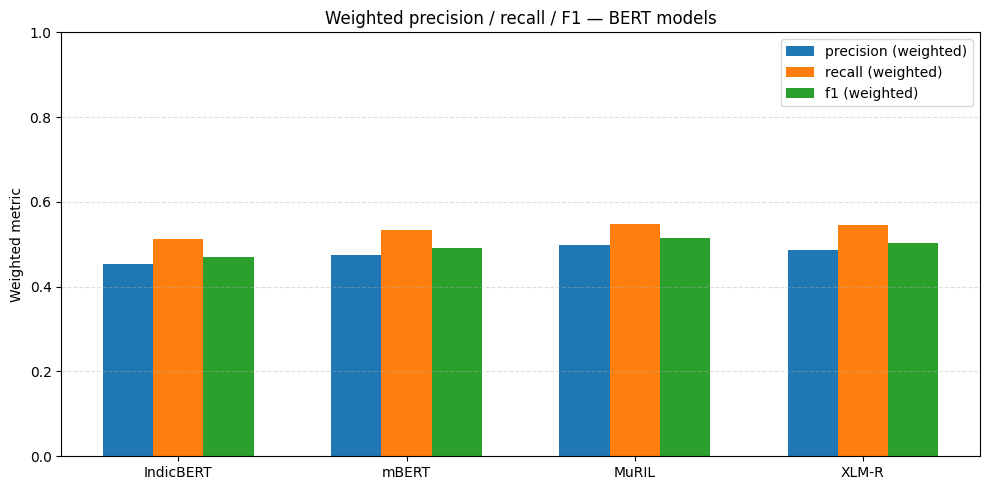

Saved plot -> bert_weighted_metrics.png


In [10]:
# Plot weighted precision/recall/F1 for IndicBERT, mBERT, MuRIL, XLM-R
# Paste and run in Colab after your training finished and artifacts are saved.

import os, re, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# config: names you want to compare (display names)
target_models = ['IndicBERT', 'mBERT', 'MuRIL', 'XLM-R']

# candidate summary CSV locations (scan these first)
candidate_csvs = [
    'model_comparison_results_weighted.csv',
    'model_comparison_XLMR_only.csv',
    './bert_models/model_comparison_results_weighted.csv',
    './model_comparison_results_weighted.csv',
    './bert_models_XLMR_only/model_comparison_XLMR_only.csv',
    './model_comparison_XLMR_only.csv'
]

def load_from_csv():
    for p in candidate_csvs:
        if os.path.exists(p):
            print("Loading summary CSV:", p)
            try:
                df = pd.read_csv(p)
                return df
            except Exception as e:
                print("Could not read", p, ":", e)
    return None

def parse_classif_report(path):
    """Parse sklearn classification_report text and return dict with weighted precision/recall/f1."""
    with open(path, 'r', encoding='utf-8') as fh:
        txt = fh.read()
    # find line that starts with 'weighted' (case-insensitive) or 'weighted avg'
    for line in txt.splitlines():
        if re.match(r'^\s*weighted', line, flags=re.I):
            parts = line.strip().split()
            # line is typically: weighted avg  <prec>  <rec>  <f1>  <support>
            # keep last 4 or 5 tokens depending spacing
            nums = [p for p in parts if re.match(r'^[0-9]*\.[0-9]+$', p) or re.match(r'^[0-9]+$', p)]
            if len(nums) >= 3:
                prec = float(nums[0]); rec = float(nums[1]); f1 = float(nums[2])
                return {'precision_weighted': prec, 'recall_weighted': rec, 'f1_weighted': f1}
    # fallback: try to extract using regex of three floats in same line
    m = re.search(r'weighted.*?([0-9]*\.[0-9]+)\s+([0-9]*\.[0-9]+)\s+([0-9]*\.[0-9]+)', txt, flags=re.I|re.S)
    if m:
        return {'precision_weighted': float(m.group(1)), 'recall_weighted': float(m.group(2)), 'f1_weighted': float(m.group(3))}
    return None

# 1) try load CSV summary first
df_summary = load_from_csv()

# normalize column names if CSV found
if df_summary is not None:
    # try to find weighted metrics columns or fall back to eval_* columns
    col_map_candidates = {
        'precision_weighted': ['precision_weighted','precision','eval_precision','precision_macro','precision'],
        'recall_weighted': ['recall_weighted','recall','eval_recall','recall_macro','recall'],
        'f1_weighted': ['f1_weighted','f1','eval_f1','f1_macro','f1']
    }
    # build mapped df with columns we need
    data_rows = []
    for _, row in df_summary.iterrows():
        name = str(row.get('model') or row.get('model_id') or row.get('model_name') or row.get('name','')).strip()
        mapped = {'model': name}
        for out_col, candidates in col_map_candidates.items():
            found = None
            for c in candidates:
                if c in row.index:
                    found = row[c]
                    break
            mapped[out_col] = float(found) if found is not None and (not pd.isna(found)) else np.nan
        data_rows.append(mapped)
    df_found = pd.DataFrame(data_rows)
else:
    df_found = pd.DataFrame(columns=['model','precision_weighted','recall_weighted','f1_weighted'])

# 2) Inspect model folders to parse classification_report.txt if metrics missing
# common root dirs
roots = ['./bert_models', './bert_models_xlmr', './', './model_outputs']
found_reports = {}
for root in roots:
    if not os.path.isdir(root):
        continue
    for model_dir in os.listdir(root):
        folder = os.path.join(root, model_dir)
        if not os.path.isdir(folder):
            continue
        # try common filenames
        candidates = [
            os.path.join(folder, 'classification_report.txt'),
            os.path.join(folder, 'classification_report', 'classification_report.txt'),
            os.path.join(folder, 'classification_report-'+model_dir+'.txt'),
            os.path.join(folder, 'classification_report.txt')
        ]
        for c in candidates:
            if os.path.exists(c):
                parsed = parse_classif_report(c)
                if parsed:
                    found_reports[model_dir] = parsed
                    break

# also try scanning entire workspace for classification_report.txt
for path in glob.glob('**/classification_report.txt', recursive=True):
    model_dir = os.path.basename(os.path.dirname(path))
    if model_dir not in found_reports:
        parsed = parse_classif_report(path)
        if parsed:
            found_reports[model_dir] = parsed

# incorporate found_reports into df_found (if not present already)
for model_dir, metrics in found_reports.items():
    # attempt to map/normalize model dir name to display names
    display_name = model_dir
    # add only if not already present (match ignoring case)
    if not any(df_found['model'].str.lower() == display_name.lower()):
        df_found = pd.concat([df_found, pd.DataFrame([{
            'model': display_name,
            'precision_weighted': metrics.get('precision_weighted', np.nan),
            'recall_weighted': metrics.get('recall_weighted', np.nan),
            'f1_weighted': metrics.get('f1_weighted', np.nan)
        }])], ignore_index=True)

# 3) Build final DataFrame for the 4 target models (case-insensitive matching)
rows = []
for name in target_models:
    # try exact match first
    mask = df_found['model'].str.lower() == name.lower()
    if mask.any():
        row = df_found[mask].iloc[0].to_dict()
        rows.append({'model': name,
                     'precision_weighted': row.get('precision_weighted', np.nan),
                     'recall_weighted': row.get('recall_weighted', np.nan),
                     'f1_weighted': row.get('f1_weighted', np.nan)})
        continue
    # try partial match: model id contains short name
    candidates = df_found[df_found['model'].str.lower().str.contains(name.lower())]
    if len(candidates)>0:
        row = candidates.iloc[0].to_dict()
        rows.append({'model': name,
                     'precision_weighted': row.get('precision_weighted', np.nan),
                     'recall_weighted': row.get('recall_weighted', np.nan),
                     'f1_weighted': row.get('f1_weighted', np.nan)})
        continue
    # not found
    print("Warning: metrics for model", name, "not found in CSV or report files. It will be skipped.")
    # append NaNs so plot knows it's missing
    rows.append({'model': name, 'precision_weighted': np.nan, 'recall_weighted': np.nan, 'f1_weighted': np.nan})

df_plot = pd.DataFrame(rows)
print("\nCollected metrics:\n", df_plot)

# drop rows where all metrics are NaN
df_plot = df_plot.dropna(how='all', subset=['precision_weighted','recall_weighted','f1_weighted']).reset_index(drop=True)

if df_plot.empty:
    raise RuntimeError("No metrics found for the requested models. Make sure summary CSV or classification_report.txt files exist.")

# Save CSV
out_csv = 'bert_weighted_metrics_summary.csv'
df_plot.to_csv(out_csv, index=False)
print("Saved summary CSV ->", out_csv)

# 4) Plot grouped bar chart (precision/recall/f1)
labels = df_plot['model'].tolist()
prec = df_plot['precision_weighted'].astype(float).tolist()
rec  = df_plot['recall_weighted'].astype(float).tolist()
f1   = df_plot['f1_weighted'].astype(float).tolist()

x = np.arange(len(labels))
width = 0.22

plt.figure(figsize=(10,5))
plt.bar(x - width, prec, width=width)
plt.bar(x, rec, width=width)
plt.bar(x + width, f1, width=width)
plt.xticks(x, labels)
plt.ylim(0,1)
plt.ylabel('Weighted metric')
plt.title('Weighted precision / recall / F1 — BERT models')
plt.legend(['precision (weighted)', 'recall (weighted)', 'f1 (weighted)'])
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

out_png = 'bert_weighted_metrics.png'
plt.savefig(out_png, dpi=200)
plt.show()
print("Saved plot ->", out_png)

/tmp/ipython-input-1860050466.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_found = pd.concat([df_found, pd.DataFrame([{


Saved CSV: bert_weighted_metrics_summary.csv
       model  precision_weighted  recall_weighted  f1_weighted
0  IndicBERT              0.6012           0.5026       0.5280
1      mBERT              0.6388           0.5637       0.5856
2      MuRIL              0.5911           0.5342       0.5527
3      XLM-R              0.6435           0.5569       0.5821


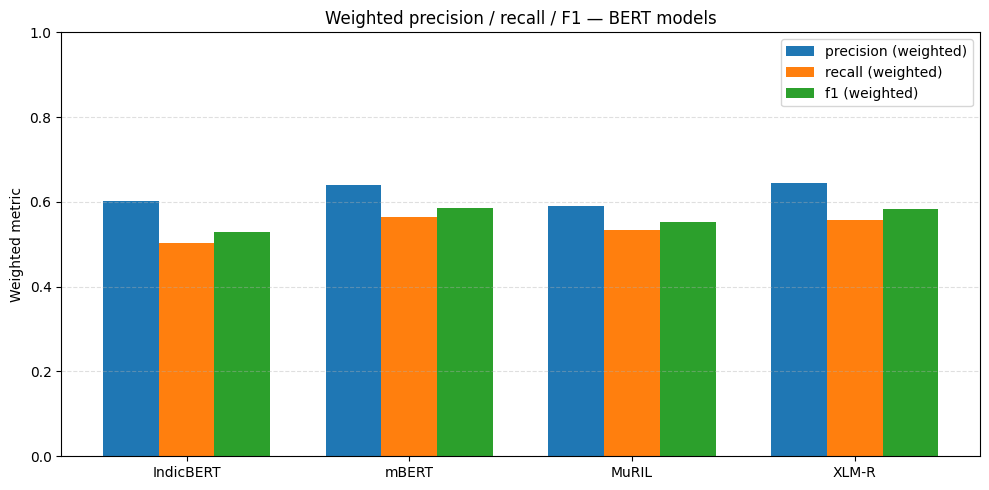

Saved plot: bert_weighted_metrics.png


In [13]:
# Colab cell: collect weighted precision/recall/F1 for IndicBERT, mBERT, MuRIL, XLM-R and plot
import os, re, glob
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# === CONFIG ===
target_models = ['IndicBERT', 'mBERT', 'MuRIL', 'XLM-R']   # display names
candidate_summary_csvs = [
    'model_comparison_results_weighted.csv',
    'model_comparison_XLMR_only.csv',
    './bert_models/model_comparison_results_weighted.csv',
    './model_comparison_results_weighted.csv',
    './bert_models_XLMR_only/model_comparison_XLMR_only.csv'
]
search_roots = ['./bert_models', './bert_models_xlmr', './', './model_outputs', './model_outputs/bert_models']

# === helpers ===
def parse_classif_report(path):
    """Return dict with weighted metrics or None."""
    text = open(path, 'r', encoding='utf-8', errors='ignore').read()
    # try find a 'weighted' line and extract three floats
    for line in text.splitlines():
        if re.match(r'^\s*weighted', line, flags=re.I):
            # extract floats from line
            nums = re.findall(r'([0-9]*\.[0-9]+)', line)
            if len(nums) >= 3:
                return {'precision_weighted': float(nums[0]), 'recall_weighted': float(nums[1]), 'f1_weighted': float(nums[2])}
    # fallback regex search
    m = re.search(r'weighted.*?([0-9]*\.[0-9]+)\s+([0-9]*\.[0-9]+)\s+([0-9]*\.[0-9]+)', text, flags=re.I|re.S)
    if m:
        return {'precision_weighted': float(m.group(1)), 'recall_weighted': float(m.group(2)), 'f1_weighted': float(m.group(3))}
    return None

def try_load_predictions_and_compute(path_prefix):
    """Look for preds/labels and compute weighted metrics. Return dict or None."""
    # try numpy files
    p_npy = os.path.join(path_prefix, 'preds.npy')
    l_npy = os.path.join(path_prefix, 'labels.npy')
    if os.path.exists(p_npy) and os.path.exists(l_npy):
        preds = np.load(p_npy)
        labels = np.load(l_npy)
        return compute_weighted_from_arrays(labels, preds)
    # try csv with two columns 'true','pred' or 'label','pred'
    for fn in glob.glob(os.path.join(path_prefix, '*.csv')):
        try:
            df = pd.read_csv(fn)
            # try common column names
            if {'true','pred'}.issubset(df.columns) or {'label','pred'}.issubset(df.columns) or {'y_true','y_pred'}.issubset(df.columns):
                if 'true' in df.columns and 'pred' in df.columns:
                    return compute_weighted_from_arrays(df['true'].to_numpy(), df['pred'].to_numpy())
                if 'label' in df.columns and 'pred' in df.columns:
                    return compute_weighted_from_arrays(df['label'].to_numpy(), df['pred'].to_numpy())
                if 'y_true' in df.columns and 'y_pred' in df.columns:
                    return compute_weighted_from_arrays(df['y_true'].to_numpy(), df['y_pred'].to_numpy())
        except Exception:
            continue
    return None

def compute_weighted_from_arrays(y_true, y_pred):
    try:
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec  = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1   = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        return {'precision_weighted': float(prec), 'recall_weighted': float(rec), 'f1_weighted': float(f1)}
    except Exception:
        return None

# === 1) Try loading any summary CSV first ===
df_found = pd.DataFrame(columns=['model','precision_weighted','recall_weighted','f1_weighted'])
for csvp in candidate_summary_csvs:
    if os.path.exists(csvp):
        try:
            df_csv = pd.read_csv(csvp)
            # try to map columns to our weighted metric names
            for _, row in df_csv.iterrows():
                name = str(row.get('model') or row.get('model_id') or row.get('name') or '').strip()
                if name=='':
                    continue
                # attempt to find weighted columns or fall back to 'precision','recall','f1'
                prec = (row.get('precision_weighted') if 'precision_weighted' in row.index else
                        row.get('precision') if 'precision' in row.index else row.get('eval_precision') if 'eval_precision' in row.index else np.nan)
                rec = (row.get('recall_weighted') if 'recall_weighted' in row.index else
                       row.get('recall') if 'recall' in row.index else row.get('eval_recall') if 'eval_recall' in row.index else np.nan)
                f1 = (row.get('f1_weighted') if 'f1_weighted' in row.index else
                      row.get('f1') if 'f1' in row.index else row.get('eval_f1') if 'eval_f1' in row.index else np.nan)
                df_found = pd.concat([df_found, pd.DataFrame([{
                    'model': name,
                    'precision_weighted': float(prec) if not pd.isna(prec) else np.nan,
                    'recall_weighted': float(rec) if not pd.isna(rec) else np.nan,
                    'f1_weighted': float(f1) if not pd.isna(f1) else np.nan
                }])], ignore_index=True)
            break
        except Exception as e:
            print("Could not read CSV", csvp, "->", e)

# === 2) Scan model directories for classification_report.txt and prediction files ===
for root in search_roots:
    if not os.path.isdir(root):
        continue
    for sub in os.listdir(root):
        folder = os.path.join(root, sub)
        if not os.path.isdir(folder):
            continue
        # parse classification_report.txt if present
        rep_path = os.path.join(folder, 'classification_report.txt')
        if os.path.exists(rep_path):
            parsed = parse_classif_report(rep_path)
            if parsed:
                df_found = pd.concat([df_found, pd.DataFrame([{
                    'model': sub,
                    'precision_weighted': parsed['precision_weighted'],
                    'recall_weighted': parsed['recall_weighted'],
                    'f1_weighted': parsed['f1_weighted']
                }])], ignore_index=True)
                continue
        # try predictions
        preds_metrics = try_load_predictions_and_compute(folder)
        if preds_metrics:
            df_found = pd.concat([df_found, pd.DataFrame([{
                'model': sub,
                'precision_weighted': preds_metrics['precision_weighted'],
                'recall_weighted': preds_metrics['recall_weighted'],
                'f1_weighted': preds_metrics['f1_weighted']
            }])], ignore_index=True)

# also scan entire workspace for classification_report.txt (recursive)
for path in glob.glob('**/classification_report.txt', recursive=True):
    model_dir = os.path.basename(os.path.dirname(path))
    if (df_found['model'].str.lower() == model_dir.lower()).any():
        continue
    parsed = parse_classif_report(path)
    if parsed:
        df_found = pd.concat([df_found, pd.DataFrame([{
            'model': model_dir,
            'precision_weighted': parsed['precision_weighted'],
            'recall_weighted': parsed['recall_weighted'],
            'f1_weighted': parsed['f1_weighted']
        }])], ignore_index=True)

# normalize model names to look up target_models (lowercase mapping)
found_map = {}
for _, r in df_found.iterrows():
    found_map[r['model'].strip().lower()] = {
        'precision_weighted': r['precision_weighted'],
        'recall_weighted': r['recall_weighted'],
        'f1_weighted': r['f1_weighted']
    }

# === 3) Build final table for target models ===
rows = []
for m in target_models:
    # try exact match (case-insensitive)
    key = None
    for k in found_map.keys():
        if k == m.lower() or m.lower() in k or k in m.lower():
            key = k
            break
    if key is None:
        # try partial contains
        candidates = [k for k in found_map.keys() if m.lower() in k]
        key = candidates[0] if candidates else None
    if key:
        vals = found_map[key]
        rows.append({'model': m,
                     'precision_weighted': float(vals.get('precision_weighted', np.nan)),
                     'recall_weighted': float(vals.get('recall_weighted', np.nan)),
                     'f1_weighted': float(vals.get('f1_weighted', np.nan))})
    else:
        print(f"Warning: no metrics found for '{m}'. Expected model folder or summary entry named like '{m}'.")
        rows.append({'model': m, 'precision_weighted': np.nan, 'recall_weighted': np.nan, 'f1_weighted': np.nan})

df_plot = pd.DataFrame(rows)

# Drop rows with all NaNs
df_plot = df_plot.dropna(how='all', subset=['precision_weighted','recall_weighted','f1_weighted']).reset_index(drop=True)
if df_plot.shape[0] == 0:
    raise RuntimeError("No weighted metrics found for requested models. Put classification_report.txt or preds/labels files in model folders or a summary CSV.")

# Save CSV
out_csv = 'bert_weighted_metrics_summary.csv'
df_plot.to_csv(out_csv, index=False)
print("Saved CSV:", out_csv)
print(df_plot)

# === 4) Plot grouped bar chart ===
labels = df_plot['model'].tolist()
prec = df_plot['precision_weighted'].astype(float).tolist()
rec = df_plot['recall_weighted'].astype(float).tolist()
f1 = df_plot['f1_weighted'].astype(float).tolist()

x = np.arange(len(labels))
w = 0.25
plt.figure(figsize=(10,5))
plt.bar(x - w, prec, width=w, label='precision (weighted)')
plt.bar(x, rec, width=w, label='recall (weighted)')
plt.bar(x + w, f1, width=w, label='f1 (weighted)')
plt.xticks(x, labels)
plt.ylim(0,1)
plt.ylabel('Weighted metric')
plt.title('Weighted precision / recall / F1 — BERT models')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
out_png = 'bert_weighted_metrics.png'
plt.savefig(out_png, dpi=200)
plt.show()
print("Saved plot:", out_png)

# Done
